In [1]:
# resource used: https://towardsdatascience.com/sentiment-analysis-of-tweets-using-multinomial-naive-bayes-1009ed24276b

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.optim.optimizer import Optimizer
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from keras.preprocessing.text import Tokenizer

In [9]:
import pickle 
infile = open('./data/Movies_and_TV_5_prep_tokenized_debug.pkl','rb')
df_movie = pickle.load(infile)
infile.close()
print(df_movie)

      Unnamed: 0                                         reviewText  overall  \
0              0  [love, shirley, maclaine, chances, really, lik...      4.0   
1              1               [totally, mesmerized, whole, series]      5.0   
2              2  [sort, film, although, think, micky, roarke, m...      2.0   
3              3  [sure, would, like, remake, enjoyed, original,...      5.0   
4              4  [wife, great, campion, fans, season, different...      5.0   
...          ...                                                ...      ...   
9995        9995  [started, watching, movie, expecting, hate, he...      2.0   
9996        9996                     [since, watched, wanted, rent]      5.0   
9997        9997  [got, movie, could, find, place, rent, reading...      2.0   
9998        9998  [believe, killed, favorite, character, omg, st...      5.0   
9999        9999  [family, enjoying, movies, video, since, cance...      5.0   

      label  
0       2.0  
1       2.0

In [10]:
# check how balanced the training dataset is
df_movie.groupby(['label']).count()

,Unnamed: 0,reviewText,overall
label,,,
0.0,1087,1087,1087
1.0,1051,1051,1051
2.0,7862,7862,7862


In [11]:
from sklearn.model_selection import train_test_split
# df_movie["reviewText"] = df_movie["reviewText"].apply(lambda x: " ".join(x))
train_X, test_X, train_y, test_y = train_test_split(df_movie['reviewText'], df_movie['label'], stratify=df_movie['label'], test_size=0.2)

In [12]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (8000,)
Test shape :  (2000,)


In [13]:
max_features = 34000 # how many unique words to use (i.e num rows in embedding vector)
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(list(train_X))
test_X = tokenizer.texts_to_sequences(list(test_X))

In [14]:
tr_data = tokenizer.sequences_to_texts(train_X)
test_data = tokenizer.sequences_to_texts(test_X)

In [16]:
# convert text data into a matrix of token counts
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(tr_data).toarray()
x_test = vectorizer.transform(test_data).toarray()

In [17]:
# transform a count matrix to a normalized tf-idf representation
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
transformer = TfidfTransformer()
x_train = transformer.fit_transform(x_train).toarray()
x_test = transformer.transform(x_test).toarray()

In [19]:
y_train = np.array(train_y)
y_test = np.array(test_y)

In [20]:
# initialize and train classifier
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

MultinomialNB()

In [25]:
prediction_test = classifier.predict(x_test)
val_preds = classifier.predict_proba(x_test)
accuracy_test = np.mean(prediction_test==y_test)
print("Accuracy (test): " + str(accuracy_test * 100) + "%")

Accuracy (test): 78.60000000000001%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

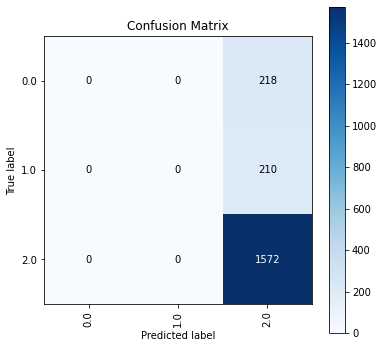

In [26]:
import scikitplot as skplt
y_true = [x for x in y_test]
y_pred = [x for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('F1: {}'.format(f1_score(y_true, y_pred, average = None)))
print('Precision: {}'.format(precision_score(y_true, y_pred, average = None)))
print('Recall: {}'.format(recall_score(y_true, y_pred, average = None)))
print(f'AUC: {roc_auc_score(y_true, val_preds, multi_class="ovr")}')


Accuracy: 0.786
F1: [0.         0.         0.88017917]
Precision: [0.    0.    0.786]
Recall: [0. 0. 1.]
AUC: 0.6568377101412206


c:\users\kajud\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


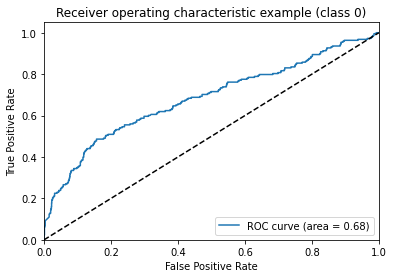

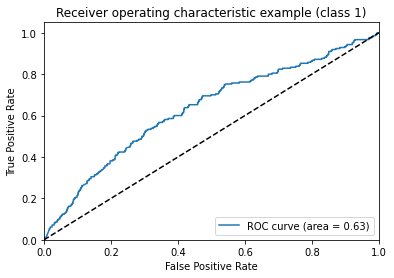

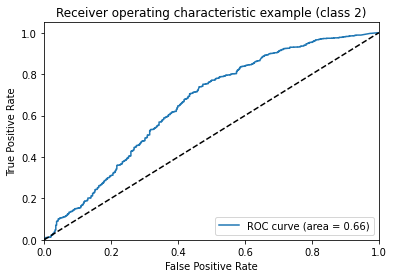

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# Creating OneHotEncoded labels for multiclasss plots
enc = OneHotEncoder(handle_unknown='ignore')
y_test = np.array(enc.fit_transform(np.array(y_true).reshape(-1, 1)).todense())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic example (class {i})')
    plt.legend(loc="lower right")
    plt.show()